**Проект заточен на то, чтобы предсказать культуру производственной безопасности (КПБ) каждого работника с помощью методов ML и DL. В конце концов, выбрать наилучшую модель для дальнейшего пользования университетом РГУ нефти и газа имени Губкина.**

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as opt
from torch.utils.data import DataLoader, Dataset

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

sns.set_style('darkgrid')

# Просмотр данных и предобработка

In [2]:
file_2020 = pd.read_excel('/kaggle/input/data-assessment/2020.xlsx')
file_2020_addition = pd.read_excel('/kaggle/input/data-assessment/2020_.xlsx')
file_2021 = pd.read_excel('/kaggle/input/data-assessment/2021.xlsx')
file_2022_2023 = pd.read_excel('/kaggle/input/data-assessment/2022_2023.xlsx')

**Сначала приведём все столбцы к одинаковому формату.**

In [ ]:
file_2020.columns

In [3]:
file_2020.columns = file_2020_addition.columns = file_2021.columns = file_2022_2023.columns = [
    'Age',
    'Experience',
    'Post',
    'The ability to perform security',
    'There were security errors',
    'There are risks at work',
    'Security status',
    "Contribution to the company's security",
    'Participation in the audit',
    'Interrupt work in case of danger',
    'КПБ'
]

In [ ]:
file_2020.head()

**Так как столбцы во всех файлах одинаковые, сделаем concat.**

In [4]:
data = pd.concat([file_2020, file_2020_addition, file_2021, file_2022_2023], axis=0, ignore_index=True)
assert len(data) == len(file_2020) + len(file_2020_addition) + len(file_2021) + len(file_2022_2023)

In [ ]:
data.head()

In [ ]:
len(data)

**Теперь необходимо исключить пропуски из данных.**

In [ ]:
data[data.isnull().any(axis=1)]

In [5]:
data = data.dropna()
len(data)

30633

**Проверим данные на наличие аномалий в каждом столбце.**

In [ ]:
data.describe()

In [ ]:
data.dtypes

In [6]:
''' Функции для работы с неопределёнными значениями'''

def not_int(x):
    if type(x) != int:
        return True

def not_float(x):
    if type(x) != float:
        return True
    
def clear_data(data, label, func):
    indexes = data[data[label].apply(lambda x: func(x)) == True].index
    print(f'количество аномалий: {len(data[data[label].apply(lambda x: func(x)) == True])}')
    data = data.drop(indexes)
    return data

In [8]:
data = clear_data(data, 'Age', not_int)

количество аномалий: 0


In [9]:
data = clear_data(data, 'Experience', not_int)

количество аномалий: 1134


In [10]:
data = clear_data(data, "Contribution to the company's security", not_int)

количество аномалий: 161


In [11]:
print(f'Количество данных после удаления аномалий в числовых столбцах: {len(data)}')

Количество данных после удаления аномалий в числовых столбцах: 29216


In [ ]:
data.columns

In [32]:
print(data['Post'].nunique())
print(data['The ability to perform security'].nunique())
print(data['There were security errors'].nunique())
print(data['There are risks at work'].nunique())
print(data['Participation in the audit'].nunique())
print(data['Interrupt work in case of danger'].nunique())

8
3
3
3
2
3


**Можно сделать вывод, что в категориальных столбцах нет аномалий, поэтому оставим всё как есть.**

# Визуализация и работа с выбросами

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Просмотр выбросов')
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0, 0].boxplot(data['Age'])
axs[0, 0].set_title('Возраст')
axs[0, 1].boxplot(data['Experience'])
axs[0, 1].set_title('Опыт')
axs[1, 0].boxplot(data['Security status'])
axs[1, 0].set_title('Оценка безопасности')
axs[1, 1].boxplot(data["Contribution to the company's security"])
axs[1, 1].set_title('Вклад в безопасность')
fig.tight_layout()

In [12]:
data = data[(data['Age'] <= 100) & (data['Age'] >= 18)]
data = data[(data['Experience'] <= 60) & (data['Experience'] >= 0)]
data = data[(data["Contribution to the company's security"] <= 100) &
            (data["Contribution to the company's security"] >= 0)]

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Просмотр выбросов')
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0, 0].boxplot(data['Age'])
axs[0, 0].set_title('Возраст')
axs[0, 1].boxplot(data['Experience'])
axs[0, 1].set_title('Опыт')
axs[1, 0].boxplot(data['Security status'])
axs[1, 0].set_title('Оценка безопасности')
axs[1, 1].boxplot(data["Contribution to the company's security"])
axs[1, 1].set_title('Вклад в безопасность')
fig.tight_layout()

In [13]:
len(data)

29022

# Подготовка данных к модели

In [14]:
X = data.drop(['КПБ'], axis=1)
y = data[['КПБ']]

In [ ]:
y.dtypes

In [ ]:
X.dtypes

In [15]:
categorical_columns = ['Post', 'The ability to perform security', 'There were security errors',
                      'There are risks at work', 'Participation in the audit',
                      'Interrupt work in case of danger']
int_columns = ['Age', 'Experience', "Contribution to the company's security"]
X[int_columns] = X[int_columns].astype('int32')
num_columns = ['Age', 'Experience', 'Security status', "Contribution to the company's security"]

In [16]:
assert len(categorical_columns) + len(num_columns) == 10

In [17]:
def encode(df, cols):
    encode_dict = {}
    for col in cols:
        print(f'{col}: преобразовалась')
        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(df[col].values) 
        df[col] = label_encoder.transform(df[col].values)
        encode_dict[col] = label_encoder
    return df, encode_dict

X_cat, encode_dict = encode(X, categorical_columns)

Post: преобразовалась
The ability to perform security: преобразовалась
There were security errors: преобразовалась
There are risks at work: преобразовалась
Participation in the audit: преобразовалась
Interrupt work in case of danger: преобразовалась


In [ ]:
encode_dict

In [18]:
scaler_dict = {}
for col in num_columns:
    scaler = StandardScaler()
    scaler_dict[col] = scaler.fit(X[col].values.reshape(-1, 1))
    X[col] = scaler_dict[col].transform(X[col].values.reshape(-1, 1))

In [19]:
X.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger
0,0.592549,0.788456,3,0,2,0,0.758893,-0.300736,0,0
1,-0.365291,0.242006,3,0,2,2,0.758893,0.837947,0,0
2,-0.046011,0.242006,3,0,2,0,0.758893,0.837947,1,0
3,0.060416,0.679166,0,0,0,0,0.758893,0.837947,0,0
4,-0.258864,0.460586,2,0,0,0,0.758893,0.837947,1,1


In [ ]:
scaler_dict

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Baseline модель

In [21]:
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train, y_train, train_size=0.9, \
                                                                     random_state=42)

base_model = LinearRegression()
base_model.fit(X_train_base, y_train_base)
preds = base_model.predict(X_val_base)

print(f'Вычисленное отклонение rmse: {np.sqrt(mean_squared_error(y_val_base, preds))}')

Вычисленное отклонение rmse: 0.43718517743224383


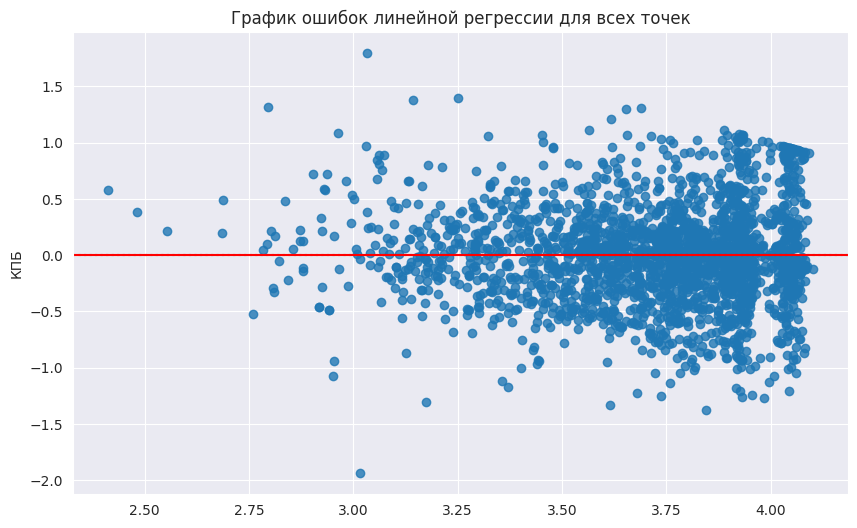

In [22]:
plt.figure(figsize=(10,6), dpi=100)
sns.residplot(x=preds, y=y_val_base);
plt.axhline(y=0, color='r');
plt.title('График ошибок линейной регрессии для всех точек');

# XGBoost, Catboost

In [ ]:
def training_model_with_randomsearch(model, X_train, y_train, X_test, y_test, params_dict):
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params_dict,
        n_iter=10,
        cv=3,
        scoring='neg_mean_squared_error', 
        verbose=1
    )
    random_search.fit(X_train, y_train)
    preds = random_search.predict(X_test)
    print("Лучшие гиперпараметры:", random_search.best_params_)
    print(f'Вычисленное значение rmse: {np.sqrt(mean_squared_error(y_test, preds))}')

In [ ]:
def training_model_with_gridsearch(model, X_train, y_train, X_test, y_test, params_dict):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params_dict,
        cv=3,
        scoring='neg_mean_squared_error',
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    preds = grid_search.predict(X_test)
    print("Лучшие гиперпараметры:", grid_search.best_params_)
    print(f'Вычисленное значение rmse: {np.sqrt(mean_squared_error(y_test, preds))}')

**XGBoost**

In [ ]:
params_dict = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.7, 0.8, 0.9]
}

xgb = XGBRegressor(tree_method='gpu_hist', random_state=42)
training_model_with_randomsearch(xgb, X_train_base, y_train_base, X_val_base, y_val_base, params_dict)

In [ ]:
params_dict = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [5, 7, 9],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9]
}

xgb = XGBRegressor(tree_method='gpu_hist', random_state=42)
training_model_with_gridsearch(xgb, X_train_base, y_train_base, X_val_base, y_val_base, params_dict)

**Catboost**

In [ ]:
params = {
    'depth': [8, 10, 12],
    'learning_rate': [0.05, 0.1],
    'iterations': [500, 700, 900],
    'l2_leaf_reg': [7, 9, 11],
}
cat = CatBoostRegressor(task_type='GPU', verbose=0)

In [ ]:
training_model_with_randomsearch(cat, X_train_base, y_train_base, X_val_base, y_val_base, params)

In [ ]:
training_model_with_gridsearch(cat, X_train_base, y_train_base, X_val_base, y_val_base, params)

# Подготовка данных к нейронке

In [23]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=42)

In [26]:
class MyDataset(Dataset):
    def __init__(self, df, num_cols, cat_cols, mode, targets):
        self.mode = mode
        self.num_data = df[num_cols].values
        self.cat_data = df[cat_cols].values
        if self.mode == 'train':
            self.targets = targets

    def __len__(self):
        return len(self.num_data) 

    def __getitem__(self, idx):
        if self.mode == 'train':
            return torch.FloatTensor(self.num_data[idx]), torch.LongTensor(self.cat_data[idx]), torch.FloatTensor(self.targets[idx])

        if self.mode == 'val':
            return torch.FloatTensor(self.num_data[idx]), torch.LongTensor(self.cat_data[idx]), None

In [29]:
train_dataset = MyDataset(X_train_new, num_columns, categorical_columns, 'train', y_train_new)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = MyDataset(X_val, num_columns, categorical_columns, 'val', y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Архитектура нейросети

**Определяем количество эмбеддингов.**

In [35]:
cat_dims = [X[col].nunique() for col in categorical_columns]
cat_embs = [(dim, min(50,(dim+1)//2)) for dim in cat_dims]
cat_embs

[(8, 4), (3, 2), (3, 2), (3, 2), (2, 1), (3, 2)]

In [37]:
class MyModel(nn.Module):
    def __init__(self, input_shape, embeddings_shape):
        super(MyModel, self).__init__()
        self.relu = nn.ReLU()

        # Создание эмбеддингов
        self.embeddings = nn.ModuleList(nn.Embedding(dim1,dim2) for dim1, dim2 in embedding_shape)
        len_emb = sum([dim2 for dim1, dim2 in embedding_shape])

        # Полносвязные слои
        self.linear_1 = nn.Linear(input_shape + len_emb, 64)
        self.linear_2 = nn.Linear(64, 32)
        self.linear_3 = nn.Linear(32, 16)
        self.linear_4 = nn.Linear(16, 1)
        
    def forward(self, num_batch, cat_batch):
        # Работаем с категориальными данными 
        x_cat = [embedding_layer(cat_batch[:, i]) for i, embedding_layer in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, 1)
        x = torch.cat([x_cat, num_batch], 1)

        # Основной проход
        x = self.relu(self.linear_1(x))
        x = self.relu(self.linear_2(x))
        x = self.relu(self.linear_3(x))
        out = self.linear_4(x)
        return out